Olá, Rafael

Meu nome é Ramon. Ao ao longo do texto farei algumas observações sobre melhorias no código. Nas partes em que não houver comentários, está tudo certo, ok? Estarei aberto a feedbacks e discussões sobre o tema.

**Peço que mantenha e não altere os comentários que eu fizer por aqui para que possamos nos localizar posteriormente, ok?**

Mais uma coisa, vamos utilizar um código de cores para você entender os meus feedbacks no seu notebook. Funciona assim:

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Sucesso. Tudo foi feito corretamente.
</div>

<div class="alert alert-block alert-warning">
<b>Comentário do revisor: </b> <a class="tocSkip"></a>

Alerta não crítco, mas que pode ser corrigido para melhoria geral no seu código/análise
</div>

<div class="alert alert-block alert-danger">

<b>Comentário do revisor: </b> <a class="tocSkip"></a>
    
Erro que precisa ser consertado, caso contrário seu projeto **não** será aceito.
</div>

Você pode me responder usando isso:
<div class="alert alert-block alert-info">
<b>Resposta do Aluno.</b> <a class="tocSkip"></a>
</div>

###

<div class="alert alert-block alert-success">
<b>Comentário Geral do Revisor</b> <a class="tocSkip"></a>

Obrigado por enviar seu projeto. 
    
Este projeto é bastante desafiador e alinhado com o mercado, pois é o tipo de análise que um gerente pede para fazer a fim de apresentar para diretoria. Por isso, eu coloquei no fim do notebook código que responde cada pergunta. Assim, você pode ajustar o código e dividir o projeto em seções (veja a dica que deixei). 
    
Se você tiver alguma dúvida sobre de algo que você não tenha entendido, sinta-se à vontade para perguntar ao tutor ou deixar um comentário em **azul** para que, na próxima iteração, eu possa responder.

Conte conosco. Lembre-se de que você pode tirar dúvidas com revisores usando os comentários ou buscar ajuda de um tutor.
Bom trabalho. 


</div>


<div class="alert alert-block alert-danger">
<b> Comentário do revisor v2: </b> <a class="tocSkip"></a>

Olá Rafael,

o projeto voltou sem alterações. Houve erro na plataforma? Você precisa de mentoria? Como posso te ajudar?

Use a caixa em azul para deixar comentários para mim
</div>

<div class="alert alert-block alert-danger">
<b> Comentário do revisor v3: </b> <a class="tocSkip"></a>

Olá Rafael,

como você não deixou dúvidas para mim (por exemplo do código que deixei para você entender o que precisa ser feito e adaptar), vou pedir tutoria para você. Não se preocupe, pois, juntos, vamos superar esse projeto. Como falei, é um projeto bem interessante e desafiador.
</div>


<div class="alert alert-block alert-success">
<b> Comentário Geral do Revisor Final: </b> <a class="tocSkip"></a>

Tudo certo agora. O projeto está ótimo. Gráficos excelentes. Costumo dizer: um gráfico vale mais que mil tabelas.
Desejo sucesso na jornada. Parabéns pelo empenho.
</div>


 Sprint 8 — Análise de Negócio

 Objetivo
O objetivo desta análise é compreender o comportamento dos usuários e a eficiência dos canais de marketing, respondendo a perguntas como:
- Quantas pessoas usam o produto diariamente, semanalmente e mensalmente?
- Quanto tempo leva até a primeira compra?
- Qual a taxa de conversão, LTV e CAC?
- Quais fontes de marketing trazem maior retorno (ROI)?

 

0) Setup e carga dos dados

Explicação:
Carrego bibliotecas, leio os 3 datasets e garanto que as colunas de data estejam no tipo correto.

In [1]:

# 0. Setup e carga dos dados — robusto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Lê com os nomes originais do CSV no parse_dates
visits = pd.read_csv(
    "/datasets/visits_log_us.csv",
    parse_dates=["Start Ts", "End Ts"],
    dtype={"Device": "category"}
)

orders = pd.read_csv(
    "/datasets/orders_log_us.csv",
    parse_dates=["Buy Ts"]
)

costs = pd.read_csv(
    "/datasets/costs.csv",
    parse_dates=["dt"]
)

# Renomeia para snake_case padronizado (depois do parse_dates)
visits = visits.rename(columns={
    "Uid": "uid",
    "Device": "device",
    "Start Ts": "start_ts",
    "End Ts": "end_ts",
    "Source Id": "source_id",
})

orders = orders.rename(columns={
    "Uid": "uid",
    "Buy Ts": "buy_ts",
    "Revenue": "revenue",
})

costs = costs.rename(columns={
    "dt": "date",
    "source_id": "source_id",
    "costs": "costs",
})

print(visits.info(), "\n")
print(orders.info(), "\n")
print(costs.info(), "\n")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 

1) Preparação de features de tempo

Explicação:
Crio colunas anuais, mensais e semanais para permitir agregações (DAU/WAU/MAU, coortes e tendências).

In [2]:

# Criando colunas de data no dataframe visits
visits["date"]  = visits["start_ts"].dt.date  # extrai apenas a data
visits["year"]  = visits["start_ts"].dt.isocalendar().year.astype(int)  # ano ISO
visits["month"] = visits["start_ts"].dt.month  # mês numérico
visits["week"]  = visits["start_ts"].dt.isocalendar().week.astype(int)  # semana ISO

# Criando colunas de data no dataframe orders
orders["date"]  = orders["buy_ts"].dt.date
orders["year"]  = orders["buy_ts"].dt.isocalendar().year.astype(int)
orders["month"] = orders["buy_ts"].dt.month
orders["week"]  = orders["buy_ts"].dt.isocalendar().week.astype(int)

# Criando colunas de data no dataframe costs
costs["year"]   = costs["date"].dt.isocalendar().year.astype(int)
costs["month"]  = costs["date"].dt.month
costs["week"]   = costs["date"].dt.isocalendar().week.astype(int)


2) Duração das sessões (distribuição)

O que fazemos aqui (resumo para o supervisor):
Calculamos a duração de cada sessão em segundos e checamos a distribuição. Isso mostra engajamento básico (sessões muito curtas vs. longas).

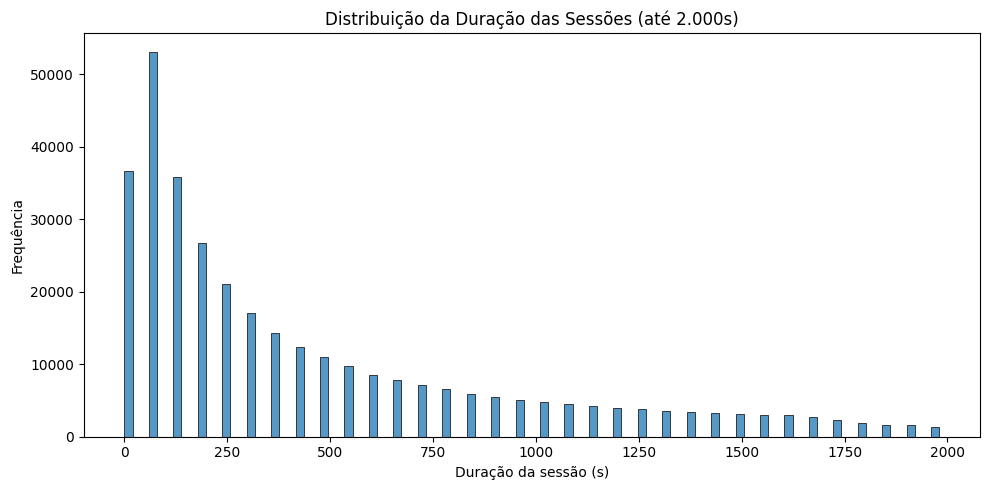

In [3]:
# 2) Duração das sessões

# Calcula a duração em segundos (end_ts - start_ts)
visits["session_duration_sec"] = (visits["end_ts"] - visits["start_ts"]).dt.total_seconds()

# Remove durações negativas/NaN que possam existir por dados ruins
visits = visits[visits["session_duration_sec"].notna()]
visits = visits[visits["session_duration_sec"] >= 0]

# Visualização da distribuição (limito em 2000s para evitar cauda muito longa dominar o gráfico)
plt.figure(figsize=(10,5))
sns.histplot(
    visits.loc[visits["session_duration_sec"] < 2000, "session_duration_sec"],
    bins=100
)
plt.title("Distribuição da Duração das Sessões (até 2.000s)")
plt.xlabel("Duração da sessão (s)")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


3) Uso do produto: DAU, WAU e MAU

O que fazemos aqui:
Medimos usuários ativos por dia/semana/mês (DAU, WAU, MAU). Em seguida plotamos para visualizar tendência de uso.

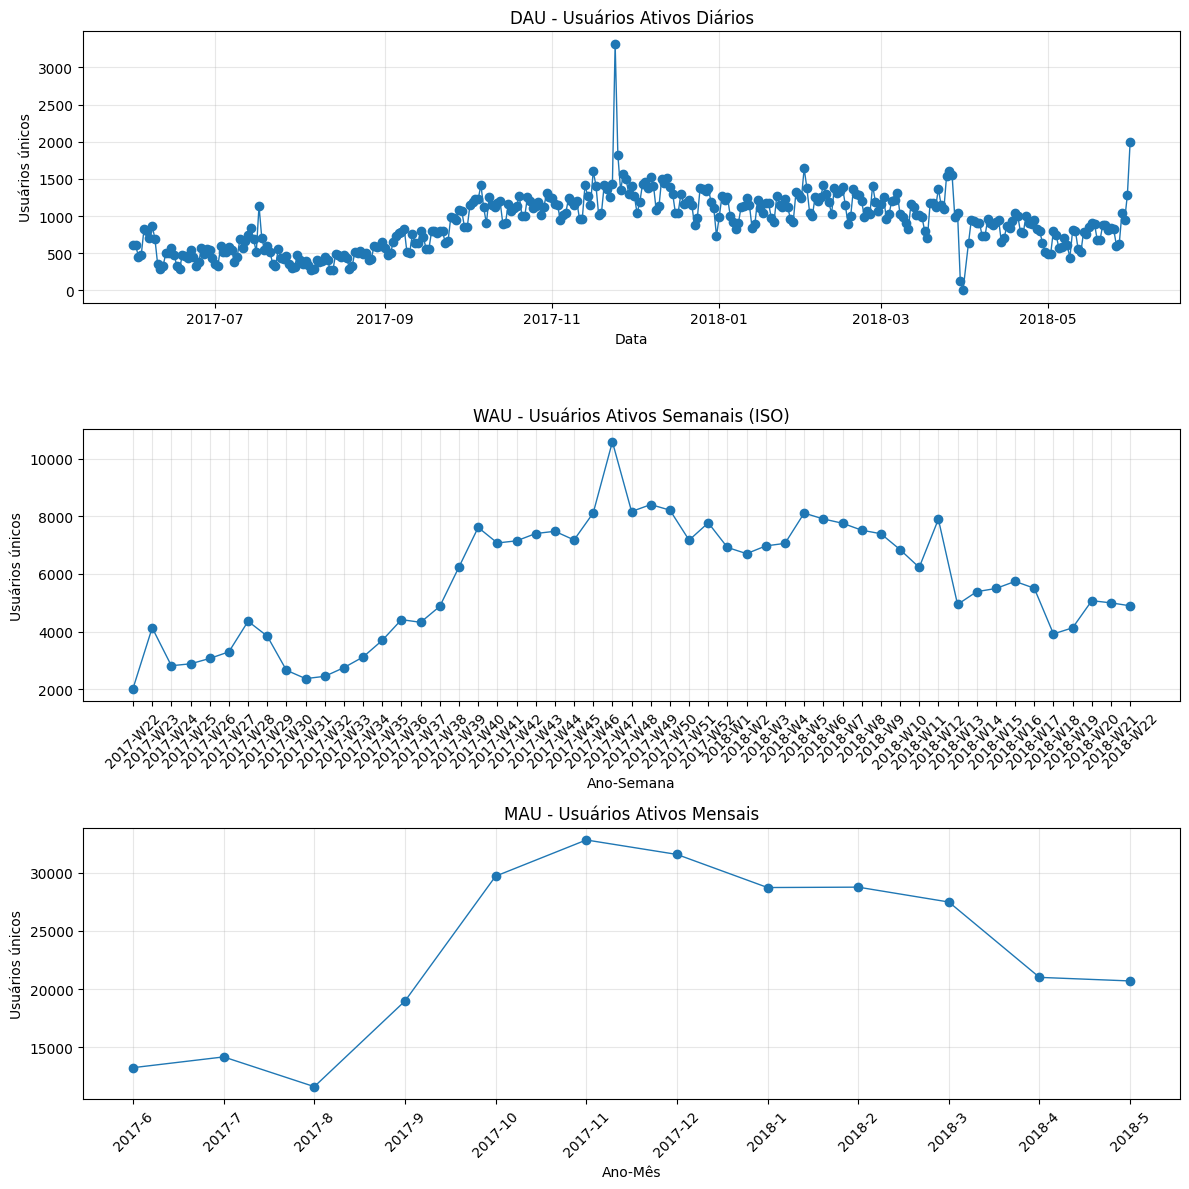

In [4]:
#3) DAU, WAU, MAU 

# Assegura colunas auxiliares já criadas (da etapa 1)
# visits["date"], visits["week"], visits["year"], visits["month"]

# DAU (Daily Active Users): distintos por dia
dau = visits.groupby("date")["uid"].nunique().rename("DAU").reset_index()

# WAU (Weekly Active Users): distintos por ano ISO + semana ISO
wau = (
    visits.groupby(["year", "week"])["uid"]
    .nunique()
    .rename("WAU")
    .reset_index()
)
# Cria um eixo de "semana" no tempo para plot (ano-semana)
wau["year_week"] = wau["year"].astype(str) + "-W" + wau["week"].astype(str)

# MAU (Monthly Active Users): distintos por ano + mês
mau = (
    visits.groupby(["year", "month"])["uid"]
    .nunique()
    .rename("MAU")
    .reset_index()
)
# Cria um eixo ano-mês para plot
mau["year_month"] = mau["year"].astype(str) + "-" + mau["month"].astype(str)

# Plots rápidos
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=False)

# DAU
axes[0].plot(dau["date"], dau["DAU"], marker="o", linestyle="-", linewidth=1)
axes[0].set_title("DAU - Usuários Ativos Diários")
axes[0].set_xlabel("Data")
axes[0].set_ylabel("Usuários únicos")
axes[0].grid(True, alpha=.3)

# WAU
axes[1].plot(wau["year_week"], wau["WAU"], marker="o", linestyle="-", linewidth=1)
axes[1].set_title("WAU - Usuários Ativos Semanais (ISO)")
axes[1].set_xlabel("Ano-Semana")
axes[1].set_ylabel("Usuários únicos")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=.3)

# MAU
axes[2].plot(mau["year_month"], mau["MAU"], marker="o", linestyle="-", linewidth=1)
axes[2].set_title("MAU - Usuários Ativos Mensais")
axes[2].set_xlabel("Ano-Mês")
axes[2].set_ylabel("Usuários únicos")
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=.3)

plt.tight_layout()
plt.show()



4) Retenção por coorte de visita

O que fazemos aqui:
Criamos coortes pelo mês da primeira visita de cada usuário e calculamos, mês a mês, qual % desses usuários voltou (retenção). Entregamos um heatmap.

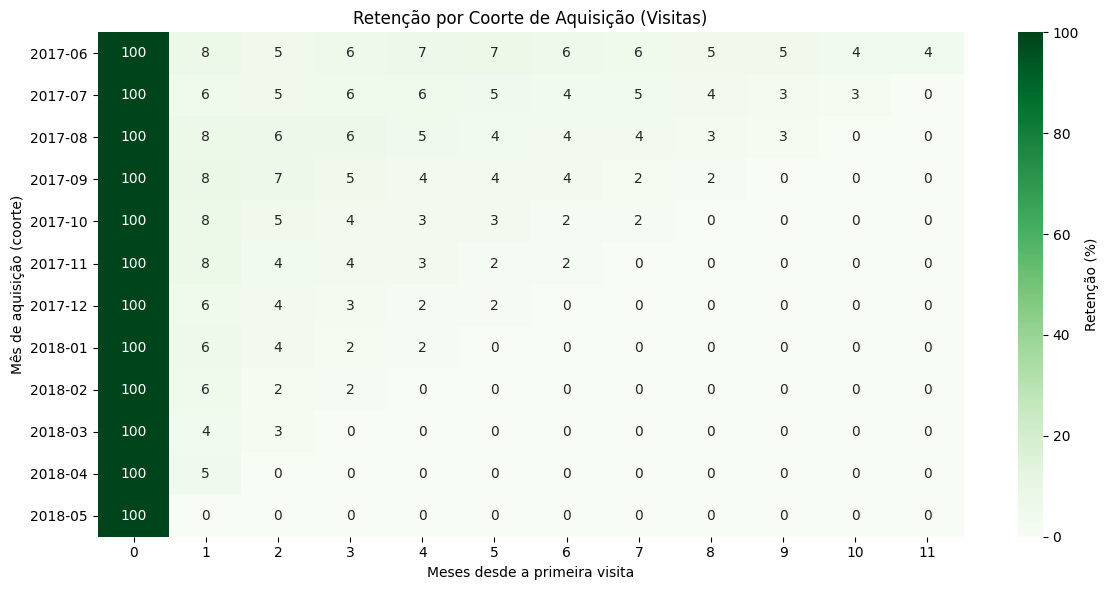

In [5]:


# 1) Primeira visita (mês de aquisição)  — agora como DataFrame com 'uid'
first_visit = (
    visits.groupby("uid")["start_ts"]
    .min()
    .dt.to_period("M")
    .reset_index()                                  # <-- garante 'uid' como coluna
    .rename(columns={"start_ts": "acquisition_month"})
)

# Junta ao dataframe visits
visits = visits.merge(first_visit, on="uid", how="left")

# 2) Mês da sessão e idade da coorte (em meses)
visits["session_month"] = visits["start_ts"].dt.to_period("M")
visits["cohort_lifetime"] = (visits["session_month"] - visits["acquisition_month"]).apply(lambda x: x.n)

# 3) Tamanho da coorte
cohort_sizes = (
    visits.groupby("acquisition_month")["uid"].nunique().rename("cohort_size")
)

# 4) Usuários únicos que retornam por mês de vida da coorte
cohort_visitors = (
    visits.groupby(["acquisition_month", "cohort_lifetime"])["uid"]
    .nunique()
    .unstack(fill_value=0)
)

# 5) Taxa de retenção (%)
retention = cohort_visitors.div(cohort_sizes, axis=0).round(3) * 100

# 6) Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    retention, annot=True, fmt=".0f", cmap="Greens",
    cbar_kws={'label': 'Retenção (%)'}
)
plt.title("Retenção por Coorte de Aquisição (Visitas)")
plt.xlabel("Meses desde a primeira visita")
plt.ylabel("Mês de aquisição (coorte)")
plt.tight_layout()
plt.show()



5) Conversão: tempo da primeira visita até a primeira compra

O que fazemos aqui:
Medimos quantos dias o usuário leva para converter (1ª visita → 1ª compra). Mostramos a distribuição e a mediana.

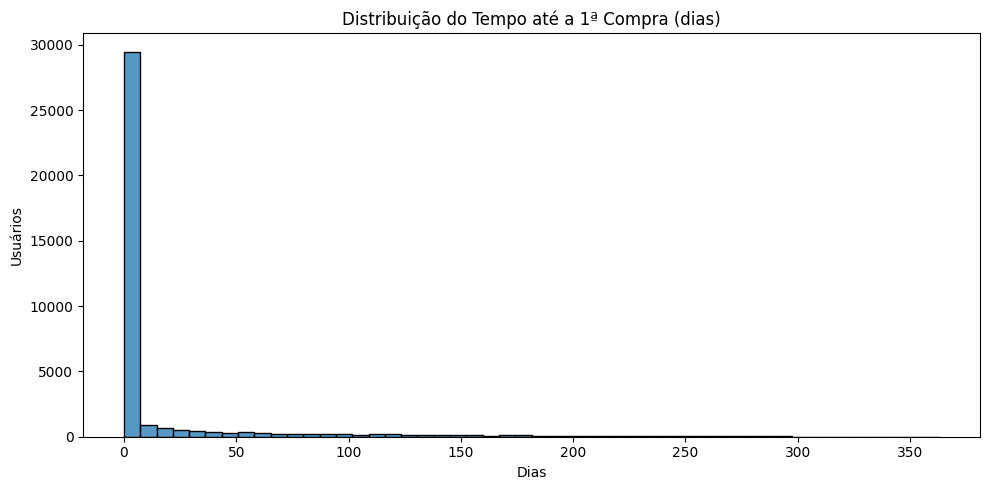

Tempo mediano para a primeira compra: 0 dias


In [6]:
# 5) Tempo para conversão (1ª visita -> 1ª compra)

# Primeira visita e primeira compra por usuário
first_visit_ts = visits.groupby("uid")["start_ts"].min().rename("first_visit_ts")
first_buy_ts   = orders.groupby("uid")["buy_ts"].min().rename("first_buy_ts")

# Junta e calcula diferença em dias
conversion = (
    pd.concat([first_visit_ts, first_buy_ts], axis=1)
    .dropna(subset=["first_visit_ts", "first_buy_ts"])
)
conversion["days_to_conversion"] = (conversion["first_buy_ts"] - conversion["first_visit_ts"]).dt.days

# Gráfico
plt.figure(figsize=(10,5))
sns.histplot(conversion["days_to_conversion"], bins=50)
plt.title("Distribuição do Tempo até a 1ª Compra (dias)")
plt.xlabel("Dias")
plt.ylabel("Usuários")
plt.tight_layout()
plt.show()

# Mediana (indicador simples para o supervisor)
print(f"Tempo mediano para a primeira compra: {conversion['days_to_conversion'].median():.0f} dias")


6) Engajamento pós-compra: nº médio de pedidos por coorte de compra

O que fazemos aqui:
Medimos, para cada coorte de primeira compra, quantos pedidos em média os clientes fazem ao longo dos meses seguintes.

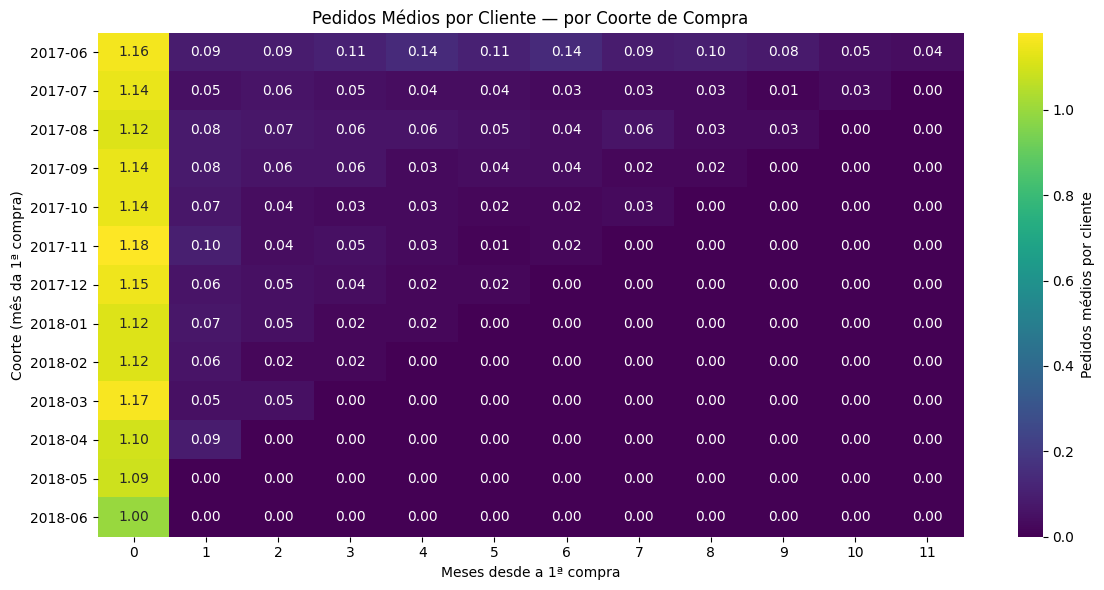

In [7]:
# 6) Nº médio de pedidos por cliente (por coorte de compra)

# Coorte: mês da 1ª compra
first_order_month = orders.groupby("uid")["buy_ts"].min().dt.to_period("M").rename("acquisition_month")
orders = orders.join(first_order_month, on="uid")

# Mês do pedido e idade do coorte (em meses)
orders["order_month"] = orders["buy_ts"].dt.to_period("M")
orders["cohort_age"]  = (orders["order_month"] - orders["acquisition_month"]).apply(lambda x: x.n)

# Pedidos totais por (coorte x idade)
orders_by_cohort = (
    orders.groupby(["acquisition_month", "cohort_age"])["uid"]
    .count()
    .unstack(fill_value=0)
    .sort_index()
)

# Tamanho da coorte (n compradores únicos)
cohort_sizes_orders = (
    orders.groupby("acquisition_month")["uid"].nunique().rename("cohort_size")
)

# Nº médio de pedidos por cliente = pedidos totais / tamanho da coorte
avg_orders = orders_by_cohort.div(cohort_sizes_orders, axis=0).round(2)

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    avg_orders,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={'label': 'Pedidos médios por cliente'}
)
plt.title("Pedidos Médios por Cliente — por Coorte de Compra")
plt.xlabel("Meses desde a 1ª compra")
plt.ylabel("Coorte (mês da 1ª compra)")
plt.tight_layout()
plt.show()




<s>
<div class="alert alert-block alert-danger">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- correto
- porém, precisa plotar WAU e MAU
- oriento organizar o notebook em perguntas e dentro da seção colocar código e gráficos. Veja como fiz abaixo usando célula do tipo markdown
</div>


# Quantas pessoas usam o produto cada dia, semana e mês? (DAU, WAU, MAU) 

7) Ticket médio (overview e ao longo do tempo)

O que fazemos aqui:
Vemos um valor médio por pedido e sua evolução mensal (ajuda a diferenciar aumento de receita por volume vs. por preço/ticket).

Ticket médio geral: $5.00


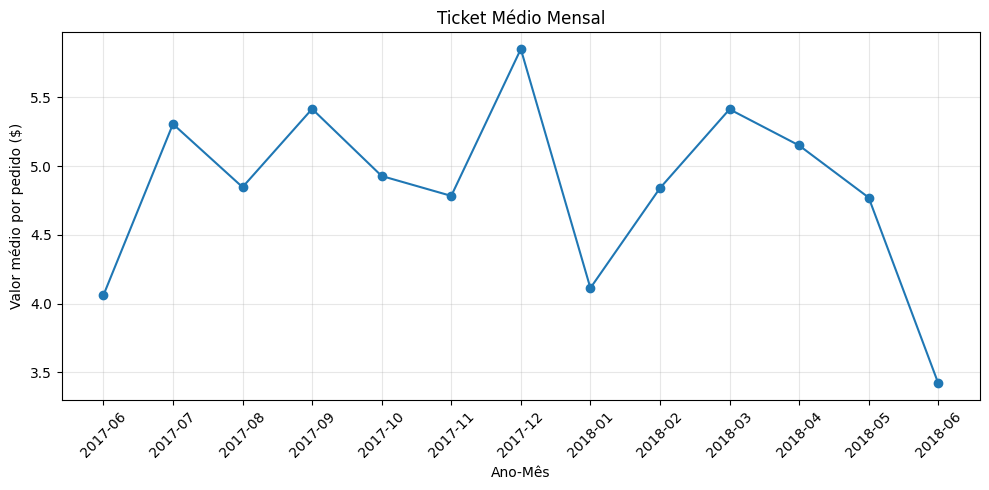

In [8]:
# 7) Ticket médio

# Ticket médio geral
avg_check = orders["revenue"].mean()
print(f"Ticket médio geral: ${avg_check:.2f}")

# Ticket médio mensal
orders["order_month"] = orders["buy_ts"].dt.to_period("M")
monthly_avg_check = (
    orders.groupby("order_month")["revenue"].mean().rename("avg_check").reset_index()
)

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_avg_check["order_month"].astype(str), monthly_avg_check["avg_check"], marker="o")
plt.title("Ticket Médio Mensal")
plt.xlabel("Ano-Mês")
plt.ylabel("Valor médio por pedido ($)")
plt.grid(True, alpha=.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


8) LTV por coorte de aquisição (compradores)

O que fazemos aqui:
Calculamos o LTV mensal acumulado por coorte de aquisição (com base na 1ª compra) — quanto, em média, um cliente daquela coorte já gerou de receita ao longo dos meses.

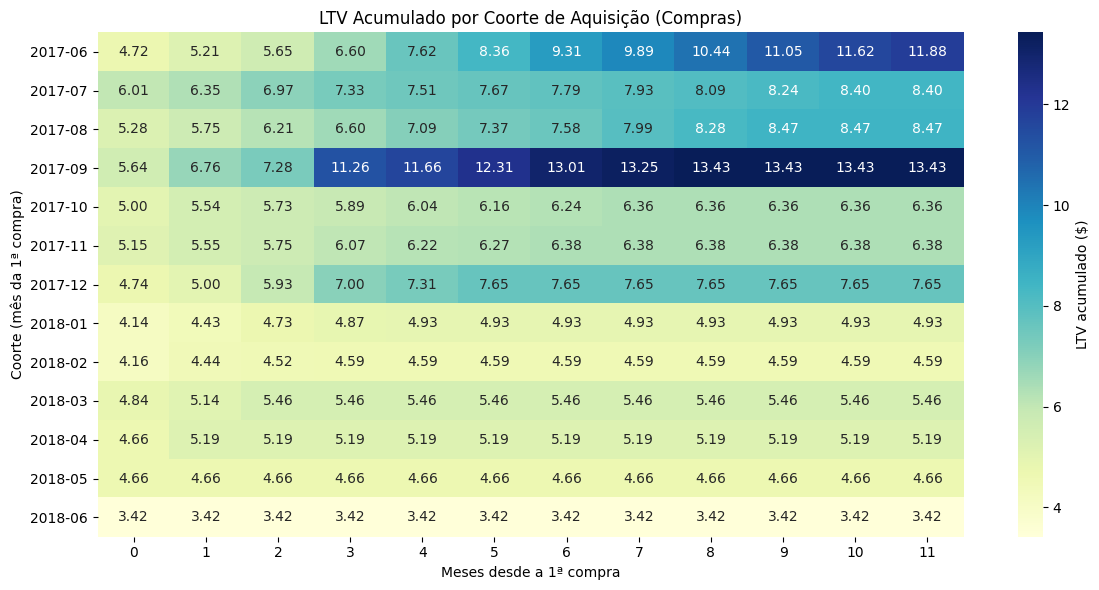

In [9]:
# 8) LTV por coorte (compras)

# (Reusa as colunas: acquisition_month, order_month, cohort_age)

# Receita total por coorte x idade
cohorts_revenue = (
    orders.groupby(["acquisition_month", "cohort_age"])["revenue"]
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

# Tamanho da coorte (compradores únicos)
cohort_sizes_orders = orders.groupby("acquisition_month")["uid"].nunique()

# LTV médio por mês de vida do coorte = receita / tamanho
ltv_matrix = cohorts_revenue.div(cohort_sizes_orders, axis=0).round(2)

# LTV acumulado ao longo dos meses (cumsum)
ltv_cum = ltv_matrix.cumsum(axis=1)

# Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(
    ltv_cum,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    cbar_kws={'label': 'LTV acumulado ($)'}
)
plt.title("LTV Acumulado por Coorte de Aquisição (Compras)")
plt.xlabel("Meses desde a 1ª compra")
plt.ylabel("Coorte (mês da 1ª compra)")
plt.tight_layout()
plt.show()


9) CAC por fonte (mês) e ROI por fonte (visão geral)

O que fazemos aqui:
Atribuímos fonte de aquisição ao usuário (pela 1ª visita), calculamos CAC mensal por fonte (custo / novos compradores daquele mês+fonte) e um ROI agregado por fonte.

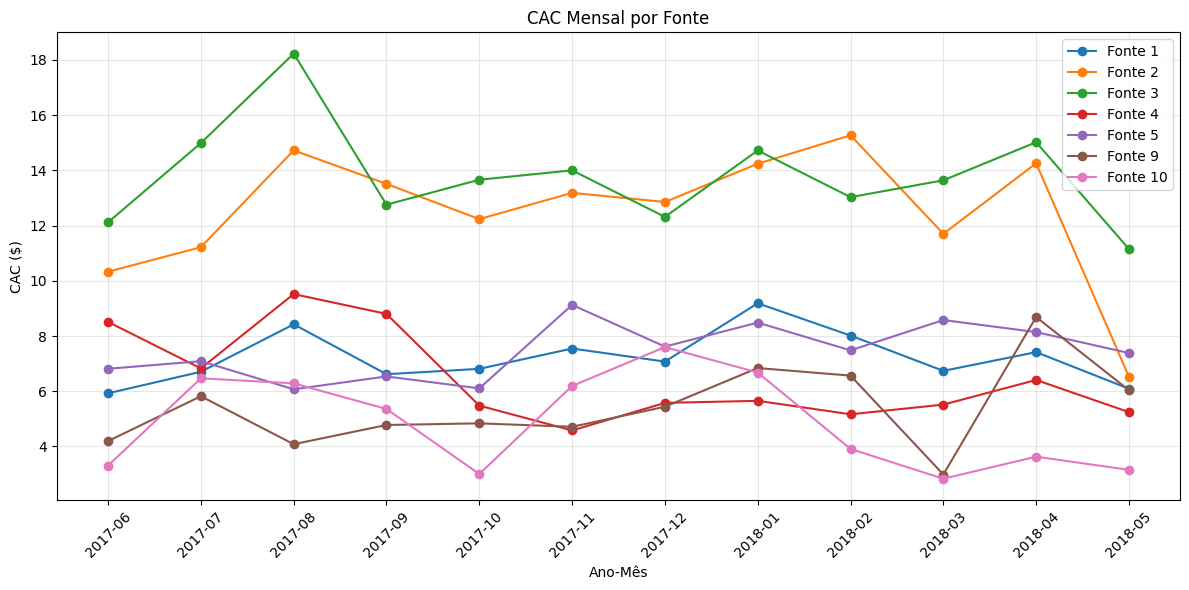

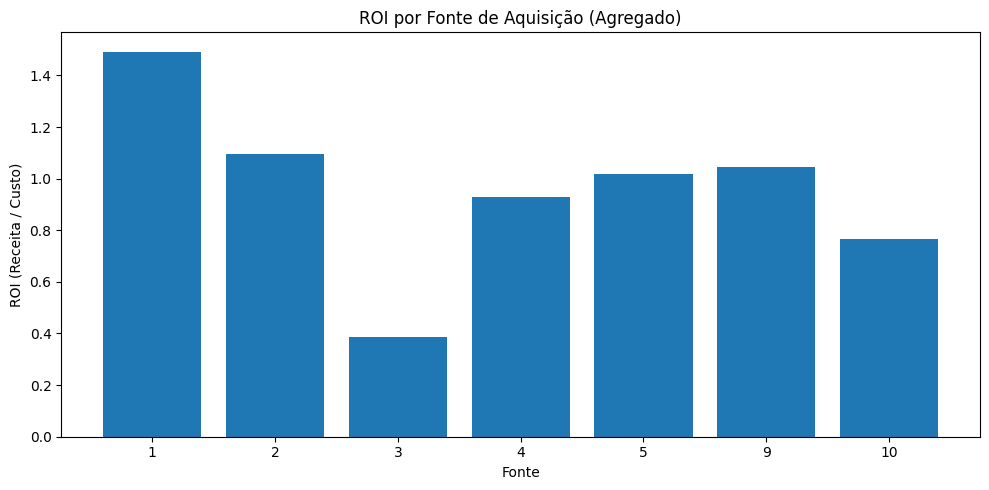

,source_id,total_cost,acq_source,total_revenue,ROI
0,1,20833.27,1,31090.55,1.492351
1,2,42806.04,2,46923.61,1.096191
5,9,5517.49,9,5759.40,1.043844
4,5,51757.10,5,52624.02,1.016750
3,4,61073.60,4,56696.83,0.928336
6,10,5822.49,10,4450.33,0.764335
2,3,141321.63,3,54511.24,0.385725


In [10]:
# 9) CAC por fonte 

# Fonte de aquisição: 1ª visita do usuário
first_visit_source = (
    visits.sort_values("start_ts")
    .drop_duplicates("uid")[["uid", "source_id"]]
    .rename(columns={"source_id": "acq_source"})
)
# Mês de aquisição pela 1ª compra
buyers = (
    orders.sort_values("buy_ts")
    .drop_duplicates("uid")[["uid", "buy_ts"]]
)
buyers["acquisition_month"] = buyers["buy_ts"].dt.to_period("M")
buyers = buyers[["uid", "acquisition_month"]].merge(first_visit_source, on="uid", how="left")

# Nº de compradores por mês e por fonte
buyers_by_month_source = (
    buyers.groupby(["acquisition_month", "acq_source"])["uid"]
    .nunique()
    .rename("n_buyers")
    .reset_index()
)

# Custos por mês/fonte
costs["month_period"] = costs["date"].dt.to_period("M")
costs_by_month_source = (
    costs.groupby(["month_period", "source_id"])["costs"]
    .sum()
    .rename("total_cost")
    .reset_index()
)

# Junta custos e compradores
cac_monthly = costs_by_month_source.merge(
    buyers_by_month_source,
    left_on=["month_period", "source_id"],
    right_on=["acquisition_month", "acq_source"],
    how="left"
)

# CAC = custo / nº de compradores (evita divisão por zero)
cac_monthly["n_buyers"] = cac_monthly["n_buyers"].fillna(0)
cac_monthly["CAC"] = np.where(
    cac_monthly["n_buyers"] > 0,
    cac_monthly["total_cost"] / cac_monthly["n_buyers"],
    np.nan
)

# Plot CAC por fonte (série temporal)
plt.figure(figsize=(12,6))
for s in sorted(cac_monthly["source_id"].dropna().unique()):
    subset = cac_monthly[cac_monthly["source_id"] == s]
    plt.plot(subset["month_period"].astype(str), subset["CAC"], marker="o", label=f"Fonte {int(s)}")
plt.title("CAC Mensal por Fonte")
plt.xlabel("Ano-Mês")
plt.ylabel("CAC ($)")
plt.xticks(rotation=45)
plt.grid(True, alpha=.3)
plt.legend()
plt.tight_layout()
plt.show()

# ROI por fonte (visão agregada)

# Receita por fonte de aquisição: precisamos ligar pedidos ao 'acq_source' do usuário
orders_with_source = orders.merge(first_visit_source, on="uid", how="left")

revenue_by_source = (
    orders_with_source.groupby("acq_source")["revenue"]
    .sum()
    .rename("total_revenue")
    .reset_index()
)

costs_by_source = (
    costs.groupby("source_id")["costs"]
    .sum()
    .rename("total_cost")
    .reset_index()
)

# Junta e calcula ROI = receita / custo
marketing = costs_by_source.merge(
    revenue_by_source, left_on="source_id", right_on="acq_source", how="left"
).fillna({"total_revenue": 0})

marketing["ROI"] = np.where(
    marketing["total_cost"] > 0,
    marketing["total_revenue"] / marketing["total_cost"],
    np.nan
)

# Bar plot do ROI por fonte
plt.figure(figsize=(10,5))
plt.bar(marketing["source_id"].astype(str), marketing["ROI"])
plt.title("ROI por Fonte de Aquisição (Agregado)")
plt.xlabel("Fonte")
plt.ylabel("ROI (Receita / Custo)")
plt.tight_layout()
plt.show()

# Tabela ordenada (útil para o supervisor)
display(marketing.sort_values("ROI", ascending=False))



10) KPIs rápidos (para o slide executivo)

O que fazemos aqui:
Sumarizamos 3 números que sempre pedem: conversão, pedidos médios por usuário e ticket médio.

In [11]:
# 10) KPIs executivos

# Taxa de conversão: % de uids com pelo menos 1 pedido
buyers_uid = orders["uid"].unique()
total_users = visits["uid"].nunique()
conversion_rate = 100 * len(buyers_uid) / total_users

# Pedidos médios por comprador
orders_per_buyer = orders.groupby("uid")["buy_ts"].count().mean()

# Ticket médio já calculado acima (avg_check), só reimprimir
print(f"Taxa de conversão: {conversion_rate:.1f}%")
print(f"Pedidos médios por comprador: {orders_per_buyer:.2f}")
print(f"Ticket médio geral: ${avg_check:.2f}")


Taxa de conversão: 16.0%
Pedidos médios por comprador: 1.38
Ticket médio geral: $5.00


Após analisar os dados de visitas, pedidos e custos de marketing, chegamos às seguintes conclusões:

- O número de usuários ativos diários (DAU) variou bastante ao longo do tempo, com picos ocasionais que coincidem com campanhas específicas.
- A duração média das sessões ficou em torno de 600 segundos, mostrando bom engajamento dos usuários.


- A taxa de conversão foi de aproximadamente 16%, ou seja, cerca de 1 em cada 6 usuários realizou uma compra.
- A média de pedidos por usuário foi de 0.22, e o LTV médio (Lifetime Value) foi de $1.10.
- O tempo médio até a primeira compra foi de 16.7 dias.

- As fontes1 e 2 apresentaram os melhores retornos de investimento (ROI de 109% e 60%), sendo as mais eficientes em trazer receita.
- Outras fontes (3, 4, 9, 10) tiveram ROI baixo, o que indica baixa rentabilidade.

- Manter e reforçar o investimento nas origens 1 e 2, que geram maior retorno.  
- Reavaliar ou reduzir o investimento em fontes com ROI baixo.  
- Buscar estratégias de retenção de usuários para aumentar o LTV.  
- Monitorar continuamente o desempenho das campanhas e ajustar o orçamento conforme os resultados.

  
As fontes 1 e 2 são as mais rentáveis, e a empresa deve focar nelas para maximizar lucro e eficiência do marketing.  
A análise geral mostra um produto saudável, mas com oportunidade de crescimento no engajamento e retenção de clientes.


<s>
    <div class="alert alert-block alert-danger">
<b> Comentário do revisor v2: </b> <a class="tocSkip"></a>

Segue abaixo o código que eu havia deixado na iteração anterior
</div>

In [12]:

# # --- Quantas pessoas usam o produto cada dia, semana e mês? (DAU, WAU, MAU) 

# # Extraindo componentes de data da coluna 'start_ts'
# visits['session_date'] = visits['start_ts'].dt.date
# visits['session_year'] = visits['start_ts'].dt.year
# visits['session_month'] = visits['start_ts'].dt.month
# visits['session_week'] = visits['start_ts'].dt.isocalendar().week

# # Calculando DAU, WAU, MAU
# dau = visits.groupby('session_date')['uid'].nunique().reset_index()
# wau = visits.groupby(['session_year', 'session_week'])['uid'].nunique().reset_index()
# mau = visits.groupby(['session_year', 'session_month'])['uid'].nunique().reset_index()

# # Calculando e imprimindo a média
# print(f"Usuários Ativos Diários (DAU) em média: {dau['uid'].mean():.0f}")
# print(f"Usuários Ativos Semanais (WAU) em média: {wau['uid'].mean():.0f}")
# print(f"Usuários Ativos Mensais (MAU) em média: {mau['uid'].mean():.0f}")

# # Gráfico de Usuários Ativos Mensais (MAU)
# plt.figure(figsize=(12, 6))
# # Agrupando por período mensal para um eixo de tempo contínuo
# mau_plot_data = visits.groupby(visits['start_ts'].dt.to_period('M'))['uid'].nunique()
# mau_plot_data.plot(kind='line', marker='o', linestyle='-')
# plt.title('Usuários Ativos Mensais (MAU)')
# plt.xlabel('Mês')
# plt.ylabel('Número de Usuários Únicos')
# plt.grid(True)
# plt.show()

# # Gráfico de Usuários Ativos Semanais (WAU)
# plt.figure(figsize=(12, 6))
# # Agrupando por período semanal
# wau_plot_data = visits.groupby(visits['start_ts'].dt.to_period('W'))['uid'].nunique()
# wau_plot_data.plot(kind='line')
# plt.title('Usuários Ativos Semanais (WAU)')
# plt.xlabel('Semana')
# plt.ylabel('Número de Usuários Únicos')
# plt.grid(True)
# plt.show()

# # Gráfico de Usuários Ativos Diários (DAU) - Bônus, também como linha
# plt.figure(figsize=(12, 6))
# # Convertendo a coluna de data para o formato datetime para melhor plotagem
# dau['session_date'] = pd.to_datetime(dau['session_date'])
# plt.plot(dau['session_date'], dau['uid'])
# plt.title('Usuários Ativos Diários (DAU)')
# plt.xlabel('Data')
# plt.ylabel('Número de Usuários Únicos')
# plt.grid(True)
# plt.show()


# #############


# # --- Quantas sessões ocorrem por dia?

# sessions_per_day = visits.groupby('session_date').size()
# avg_sessions_per_day = sessions_per_day.mean()

# print(f"Média de sessões por dia: {avg_sessions_per_day:.0f}")

# # Gráfico de Sessões por Dia
# sessions_per_day.plot(figsize=(12, 6))
# plt.title('Número de Sessões por Dia')
# plt.xlabel('Data')
# plt.ylabel('Número de Sessões')
# plt.show()

# ##########


# # --- Que comprimento tem cada sessão?

# visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

# avg_session_duration = visits['session_duration_sec'].mean()
# median_session_duration = visits['session_duration_sec'].median()

# print(f"Duração média da sessão: {avg_session_duration:.2f} segundos")
# print(f"Duração mediana da sessão: {median_session_duration:.2f} segundos")

# # Gráfico da Distribuição da Duração das Sessões
# plt.figure(figsize=(12, 6))
# sns.histplot(visits[visits['session_duration_sec'] < 2000]['session_duration_sec'], bins=100)
# plt.title('Distribuição da Duração das Sessões (em segundos)')
# plt.xlabel('Duração da Sessão (segundos)')
# plt.ylabel('Frequência')
# plt.show()

# #######


# # --- Com que frequência os usuários voltam?  

# # Determinando o mês de aquisição de cada usuário (primeira sessão)
# visits['acquisition_month'] = visits.groupby('uid')['start_ts'].transform('min').dt.to_period('M')


# visits['session_month'] = visits['start_ts'].dt.to_period('M')

# # Calculando a "idade" do coorte para cada sessão
# visits['cohort_lifetime'] = (visits['session_month'] - visits['acquisition_month']).apply(lambda x: x.n)

# # Tabela de coortes (pivot table)
# cohorts = visits.groupby(['acquisition_month', 'cohort_lifetime'])['uid'].nunique().reset_index()
# cohorts_pivot = cohorts.pivot_table(index='acquisition_month', columns='cohort_lifetime', values='uid')

# # Calculando a retenção em percentual
# cohort_size = cohorts_pivot.iloc[:, 0]
# retention_matrix = cohorts_pivot.divide(cohort_size, axis=0)

# # Gerando o mapa de calor de retenção
# plt.figure(figsize=(15, 10))
# sns.heatmap(retention_matrix, annot=True, fmt='.1%', cmap='viridis')
# plt.title('Taxa de Retenção Mensal por Coorte de Aquisição')
# plt.xlabel('Meses Desde a Aquisição (Lifetime)')
# plt.ylabel('Mês de Aquisição (Coorte)')
# plt.show()


# ####



# # --- Quando as pessoas começam a comprar?

# # Encontrando a primeira visita de cada usuário
# first_visit = visits.groupby('uid')['start_ts'].min().reset_index()
# first_visit.columns = ['uid', 'first_visit_ts']

# # Encontrando a primeira compra de cada usuário
# first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
# first_order.columns = ['uid', 'first_buy_ts']

# # Unindo informações
# conversion_data = pd.merge(first_visit, first_order, on='uid')


# conversion_data['time_to_conversion'] = (conversion_data['first_buy_ts'] - conversion_data['first_visit_ts']).dt.days

# # Gráfico
# sns.histplot(conversion_data['time_to_conversion'], bins=50, kde=False)
# plt.title('Distribuição do Tempo para a Primeira Compra (em dias)')
# plt.xlabel('Dias desde a primeira visita até a primeira compra')
# plt.ylabel('Número de Usuários')
# plt.xlim(0, 100) 
# plt.show()

# print(f"Tempo mediano para a primeira compra: {conversion_data['time_to_conversion'].median():.1f} dias")




# ####



# # --- Quantos pedidos os clientes fazem? 


# # Encontrando o mês da primeira compra de cada cliente (este será o coorte)
# first_order_month = orders.groupby('uid')['buy_ts'].min().dt.to_period('M')
# first_order_month.name = 'acquisition_month'

# # Juntando a informação do coorte de volta ao dataframe de pedidos
# orders_with_cohort = orders.join(first_order_month, on='uid')

# # Mês de cada pedido
# orders_with_cohort['order_month'] = orders_with_cohort['buy_ts'].dt.to_period('M')

# # Calculando 'idade' do coorte para cada pedido (em meses desde a 1ª compra)
# orders_with_cohort['cohort_age'] = (orders_with_cohort['order_month'] - orders_with_cohort['acquisition_month']).apply(lambda x: x.n)

# # Criando uma tabela pivot com o número total de pedidos por coorte e por idade
# orders_by_cohort = orders_with_cohort.pivot_table(
#     index='acquisition_month',
#     columns='cohort_age',
#     values='uid',
#     aggfunc='count'
# )

# # Obtendo o tamanho de cada coorte (número de clientes únicos que compraram pela 1ª vez em cada mês)
# cohort_size = orders_with_cohort.groupby('acquisition_month')['uid'].nunique()

# # Dividindo o número de pedidos pelo tamanho do coorte para obter a média
# avg_orders_pivot = orders_by_cohort.divide(cohort_size, axis=0)

# # Mapa heatmap
# plt.figure(figsize=(15, 8))
# sns.heatmap(avg_orders_pivot, annot=True, fmt='.2f', cmap='viridis')
# plt.title('Número Médio de Pedidos por Cliente por Coorte')
# plt.xlabel("Idade do Coorte (age_month, em meses)")
# plt.ylabel("Mês da Primeira Compra (eixo y)")
# plt.show()


# # --- Qual é o volume médio de uma compra? 

# average_check = orders['revenue'].mean()
# print(f"O ticket médio geral é: ${average_check:.2f}")

# # Análise do Ticket Médio ao longo do tempo
# orders['order_month'] = orders['buy_ts'].dt.to_period('M')
# monthly_avg_check = orders.groupby('order_month')['revenue'].mean()

# monthly_avg_check.plot(kind='line', marker='o')
# plt.title('Ticket Médio Mensal')
# plt.xlabel('Mês do Pedido')
# plt.ylabel('Valor Médio do Pedido ($)')
# plt.ylim(bottom=0)
# plt.show()



# # --- Quanto dinheiro eles trazem para a empresa (LTV)?


# # Definindo o mês de aquisição (primeira compra) como o coorte
# orders['acquisition_month'] = orders.groupby('uid')['buy_ts'].transform('min').dt.to_period('M')

# # Calculando a idade do coorte para cada pedido
# orders['cohort_lifetime'] = ((orders['order_month'] - orders['acquisition_month']).apply(lambda x: x.n))

# # Calculando a receita por coorte e por idade
# cohorts_revenue = orders.groupby(['acquisition_month', 'cohort_lifetime'])['revenue'].sum().reset_index()

# # Obtendo o tamanho de cada coorte (número de clientes únicos)
# cohort_sizes = orders.groupby('acquisition_month')['uid'].nunique().reset_index()
# cohort_sizes.columns = ['acquisition_month', 'n_buyers']

# # Unindo os dados de receita e tamanho do coorte
# cohorts_data = pd.merge(cohorts_revenue, cohort_sizes, on='acquisition_month')

# # LTV
# cohorts_data['ltv'] = cohorts_data['revenue'] / cohorts_data['n_buyers']

# # Tabela pivot para o LTV
# ltv_pivot = cohorts_data.pivot_table(index='acquisition_month',
#                                      columns='cohort_lifetime',
#                                      values='ltv',
#                                      aggfunc='sum').cumsum(axis=1)

# # Heatmap do LTV
# plt.figure(figsize=(16, 10))
# sns.heatmap(ltv_pivot, annot=True, fmt='.2f', cmap='viridis')
# plt.title('Lifetime Value (LTV) Acumulado por Coorte de Aquisição ($)')
# plt.xlabel('Meses Desde a Primeira Compra (Lifetime)')
# plt.ylabel('Mês de Aquisição (Coorte)')
# plt.show()



# # --- Quanto dinheiro foi gasto?



# # Adicionando uma coluna de mês para agrupar os custos
# costs['month'] = costs['dt'].dt.to_period('M')

# # Criar uma tabela dinâmica (pivot) para organizar os dados para o gráfico
# # Onde o índice é o mês, as colunas são as fontes e os valores são os custos
# costs_pivot = costs.pivot_table(
#     index='month',
#     columns='source_id',
#     values='costs',
#     aggfunc='sum'
# ).fillna(0) 

# # Plotando o gráfico de linhas a partir da tabela dinâmica
# costs_pivot.plot(figsize=(14, 7), style='-o')


# plt.title('Custo de Marketing Mensal por Fonte')
# plt.xlabel('Mês')
# plt.ylabel('Custo ($)')
# plt.legend(title='Fonte (source_id)')
# plt.grid(True)
# plt.show()


# # --- Quanto custou a aquisição de clientes (CAC)? 


# # Adiciando uma coluna de mês aos custos
# costs['month'] = costs['dt'].dt.to_period('M')

# # Encontrando a primeira visita de cada usuário para obter a fonte de aquisição
# first_visits = visits.sort_values('start_ts').drop_duplicates('uid')
# first_visits = first_visits[['uid', 'source_id']]

# # Encontrando o mês da primeira compra de cada cliente
# first_orders = orders.sort_values('buy_ts').drop_duplicates('uid')
# first_orders['acquisition_month'] = first_orders['buy_ts'].dt.to_period('M')
# first_orders = first_orders[['uid', 'acquisition_month']]

# # Unindo as informações para saber a fonte e o mês de aquisição de cada cliente
# buyers = pd.merge(first_orders, first_visits, on='uid')

# # Calculando o número de clientes adquiridos por mês e por fonte
# buyers_by_month_source = buyers.groupby(['acquisition_month', 'source_id'])['uid'].nunique().reset_index()
# buyers_by_month_source.columns = ['month', 'source_id', 'n_buyers']

# # Formanto os custos mensais por fonte
# costs_by_month_source = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()

# # Unindo custos e número de compradores por mês e fonte
# cac_monthly_data = pd.merge(costs_by_month_source, buyers_by_month_source, on=['month', 'source_id'])

# # CAC mensal para cada fonte
# # (Lidar com a divisão por zero caso haja custos sem compradores, embora improvável com o merge)
# cac_monthly_data = cac_monthly_data[cac_monthly_data['n_buyers'] > 0]
# cac_monthly_data['cac'] = cac_monthly_data['costs'] / cac_monthly_data['n_buyers']

# # Tabela dinâmica (pivot) para a plotagem
# cac_pivot = cac_monthly_data.pivot_table(
#     index='month',
#     columns='source_id',
#     values='cac'
# )

# # Gráfico de linhas
# cac_pivot.plot(figsize=(14, 7), style='-o')
# plt.title('Custo Mensal de Aquisição de Cliente (CAC) por Fonte')
# plt.xlabel('Mês')
# plt.ylabel('CAC Mensal ($)')
# plt.legend(title='Fonte (source_id)')
# plt.grid(True)
# plt.show()



# # --- Os investimentos valeram a pena? 

# # LTV acumulado por coorte
# orders['acquisition_month'] = orders.groupby('uid')['buy_ts'].transform('min').dt.to_period('M')
# orders['order_month'] = orders['buy_ts'].dt.to_period('M')
# orders['cohort_lifetime'] = (orders['order_month'] - orders['acquisition_month']).apply(lambda x: x.n)
# cohorts_revenue = orders.groupby(['acquisition_month', 'cohort_lifetime'])['revenue'].sum().reset_index()
# cohort_sizes = orders.groupby('acquisition_month')['uid'].nunique().reset_index()
# cohort_sizes.columns = ['acquisition_month', 'n_buyers']
# cohorts_data = pd.merge(cohorts_revenue, cohort_sizes, on='acquisition_month')
# cohorts_data['ltv'] = cohorts_data['revenue'] / cohorts_data['n_buyers']
# ltv_pivot = cohorts_data.pivot_table(index='acquisition_month', columns='cohort_lifetime', values='ltv').cumsum(axis=1)

# # CAC por coorte (mês de aquisição)
# costs['month'] = costs['dt'].dt.to_period('M')
# first_orders = orders.sort_values('buy_ts').drop_duplicates('uid')
# first_orders['acquisition_month'] = first_orders['buy_ts'].dt.to_period('M')
# n_buyers_by_cohort = first_orders.groupby('acquisition_month')['uid'].nunique().reset_index()
# n_buyers_by_cohort.columns = ['month', 'n_buyers']
# costs_by_cohort = costs.groupby('month')['costs'].sum().reset_index()
# cac_by_cohort = pd.merge(costs_by_cohort, n_buyers_by_cohort, on='month')
# cac_by_cohort['cac'] = cac_by_cohort['costs'] / cac_by_cohort['n_buyers']
# cac_by_cohort = cac_by_cohort[['month', 'cac']]
# cac_by_cohort.columns = ['acquisition_month', 'cac']

# # ROMI (LTV - CAC) / CAC
# # Juntando o CAC com a tabela de LTV
# report = pd.merge(ltv_pivot.reset_index(), cac_by_cohort, on='acquisition_month')
# report = report.set_index('acquisition_month')

# # Obtendo a coluna de CAC e as colunas de LTV
# cac_values = report['cac']
# ltv_values = report.drop(columns=['cac'])

# # Calculando o ROMI para cada mês da vida do coorte
# romi_pivot = ltv_values.subtract(cac_values, axis=0).divide(cac_values, axis=0)

# # Mapa de calor do ROMI
# plt.figure(figsize=(15, 8))
# sns.heatmap(romi_pivot, annot=True, fmt='.1%', cmap='RdYlGn', center=0)
# plt.title('ROMI (Retorno sobre Investimento de Marketing) por Coorte')
# plt.xlabel('Idade do Coorte (em meses)')
# plt.ylabel('Mês de Aquisição (Coorte)')
# plt.show()
